## Recreating Experiment 1, Levin et al., 2018 

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import orthogonal_procrustes
from sklearn.utils.validation import check_is_fitted
from tqdm.notebook import tqdm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from graspy.simulations import rdpg
from graspy.embed.base import BaseEmbed
from graspy.plot import heatmap, pairplot
from graspy.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [28]:
# Copyright (c) Microsoft Corporation and contributors.
# Licensed under the MIT License.

import warnings
import numpy as np
from sklearn.utils.validation import check_is_fitted

from .base import BaseEmbed
from ..utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)


class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    Class for computing the adjacency spectral embedding of a graph.

    The adjacency spectral embedding (ASE) is a k-dimensional Euclidean representation
    of the graph based on its adjacency matrix. It relies on an SVD to reduce
    the dimensionality to the specified k, or if k is unspecified, can find a number of
    dimensions automatically (see :class:`~graspologic.embed.selectSVD`).

    Read more in the :ref:`tutorials <embed_tutorials>`

    Parameters
    ----------
    n_components : int or None, default = None
        Desired dimensionality of output data. If "full",
        n_components must be <= min(X.shape). Otherwise, n_components must be
        < min(X.shape). If None, then optimal dimensions will be chosen by
        :func:`~graspologic.embed.select_dimension` using ``n_elbows`` argument.

    n_elbows : int, optional, default: 2
        If ``n_components=None``, then compute the optimal embedding dimension using
        :func:`~graspologic.embed.select_dimension`. Otherwise, ignored.

    algorithm : {'randomized' (default), 'full', 'truncated'}, optional
        SVD solver to use:

        - 'randomized'
            Computes randomized svd using
            :func:`sklearn.utils.extmath.randomized_svd`
        - 'full'
            Computes full svd using :func:`scipy.linalg.svd`
        - 'truncated'
            Computes truncated svd using :func:`scipy.sparse.linalg.svds`

    n_iter : int, optional (default = 5)
        Number of iterations for randomized SVD solver. Not used by 'full' or
        'truncated'. The default is larger than the default in randomized_svd
        to handle sparse matrices that may have large slowly decaying spectrum.

    check_lcc : bool , optional (default = True)
        Whether to check if input graph is connected. May result in non-optimal
        results if the graph is unconnected. If True and input is unconnected,
        a UserWarning is thrown. Not checking for connectedness may result in
        faster computation.

    diag_aug : bool, optional (default = True)
        Whether to replace the main diagonal of the adjacency matrix with a vector
        corresponding to the degree (or sum of edge weights for a weighted network)
        before embedding. Empirically, this produces latent position estimates closer
        to the ground truth.

    concat : bool, optional (default False)
        If graph is directed, whether to concatenate left and right (out and in) latent positions along axis 1.



    Attributes
    ----------
    n_features_in_: int
        Number of features passed to the fit method.
    latent_left_ : array, shape (n_samples, n_components)
        Estimated left latent positions of the graph.
    latent_right_ : array, shape (n_samples, n_components), or None
        Only computed when the graph is directed, or adjacency matrix is assymetric.
        Estimated right latent positions of the graph. Otherwise, None.
    singular_values_ : array, shape (n_components)
        Singular values associated with the latent position matrices.

    See Also
    --------
    graspologic.embed.selectSVD
    graspologic.embed.select_dimension

    Notes
    -----
    The singular value decomposition:

    .. math:: A = U \Sigma V^T

    is used to find an orthonormal basis for a matrix, which in our case is the
    adjacency matrix of the graph. These basis vectors (in the matrices U or V) are
    ordered according to the amount of variance they explain in the original matrix.
    By selecting a subset of these basis vectors (through our choice of dimensionality
    reduction) we can find a lower dimensional space in which to represent the graph.

    References
    ----------
    .. [1] Sussman, D.L., Tang, M., Fishkind, D.E., Priebe, C.E.  "A
       Consistent Adjacency Spectral Embedding for Stochastic Blockmodel Graphs,"
       Journal of the American Statistical Association, Vol. 107(499), 2012"""

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph):
        """
        Fit ASE model to input graph

        Parameters
        ----------
        graph : array_like or networkx.Graph
            Input graph to embed.

        Returns
        -------
        self : object
            Returns an instance of self.
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)

        # for out-of-sample
        inv_eigs = np.diag(1 / self.singular_values_)
        self.pinv_left_ = self.latent_left_ @ inv_eigs
        if self.latent_right_ is not None:
            self.pinv_right_ = self.latent_right_ @ inv_eigs

        self.is_fitted_ = True
        return self

    def predict(self, y):
        """
        Predict an out-of-sample embedding from a vertex not in the original fitted matrix.
        For more details, see [1].

        Parameters
        ----------
        y : array_like or tuple, shape (n_oos_samples, n_vertices)
            out-of-sample matrix.
            If tuple, graph is directed and y[0] contains edges from y to other nodes.

        Returns
        -------
        array_like or tuple
            Out-of-sample prediction for the latent position(s) of y.

        References
        ----------
        .. [1] Levin, K., Roosta-Khorasani, F., Mahoney, M. W., & Priebe, C. E. (2018).
        Out-of-sample extension of graph adjacency spectral embedding. PMLR: Proceedings
        of Machine Learning Research, 80, 2975-2984.
        """

        # checks
        check_is_fitted(self, "is_fitted_")
        if not np.array_equal(a, a.astype(bool)):
            raise ValueError("Out-of-sample array must be unweighted.")

        # workhorse code
        if self.latent_right_ is None:  # undirected
            if not isinstance(y, np.ndarray):
                raise TypeError("Undirected graphs require array input")
            return y @ self.pinv_left_
        else:  # directed
            if not isinstance(y, tuple):
                raise TypeError(
                    "Directed graphs require a tuple (y_right, y_left) as input."
                )
            return y[0] @ self.pinv_left_, y[1] @ self.pinv_right_

![Figure 1](../figs/figure1_original.png)

Empirical distribution of the LLS OOS estimate for 100 independent trials for number of vertices n = 50 (left), n = 100 (middle) and n = 500 (right). Each plot shows the positions of 100 independent OOS embeddings, indicated by crosses, and colored according to cluster membership. Contours indicate two generalized standard deviations of the multi- variate normal (i.e., 68% and 95% of the probability mass) about the true latent positions, which are indicated by solid circles. We note that even with merely 100 vertices, the normal approximation is already quite reasonable.

In [47]:
def confidence_ellipse(data, ax, mean=None, n_std=3.0, facecolor='none', **kwargs):
    """
    make confidence ellipse for plot
    """
    x, y = data[:, 0], data[:, 1]
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    if mean is None:
        mean_x = np.mean(x)
    else:
        mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    if mean is None:
        mean_y = np.mean(y)
    else:
        mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def trial(n, directed=False):
    # known parameters
    labels = ["blue"]*n + ["red"]*n
    lamb = np.array([0.4, 1-.4])
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])
    latents = np.vstack((x1, x2))
    
    # generate latent positions
    latents = np.repeat(latents, n, axis=0)

    # generate M from rdpg
    M = rdpg(latents, directed=directed)

    # index out oos
    p = np.repeat(lamb, n) / n
    i = np.random.choice(n*2, p=p)
    label = labels[i]
    a = np.delete(M[i, :], i)
    if directed:
        a2 = np.delete(M[:, i], i)
        a = (a, a2)
    A = np.delete(np.delete(M, i, 0), i, 1)
    latents_ = np.delete(latents, i, 0)

    # embed without oos stuff
    ase = AdjacencySpectralEmbed(n_components=2)
    ase.fit(A)

    # Procrustes alignment
    R, _ = orthogonal_procrustes(ase.latent_left_, latents_)
    if directed:
        R_right_, _ = orthogonal_procrustes(ase.latent_right_, latents_)

    # predict oos
    w = ase.predict(a)
    if not directed:
        w = w @ R
    else:
        w_left_ = w[0] @ R
        w_right_ = w[1] @ R_right_
        w = (w_left_, w_right_)

    return w, label

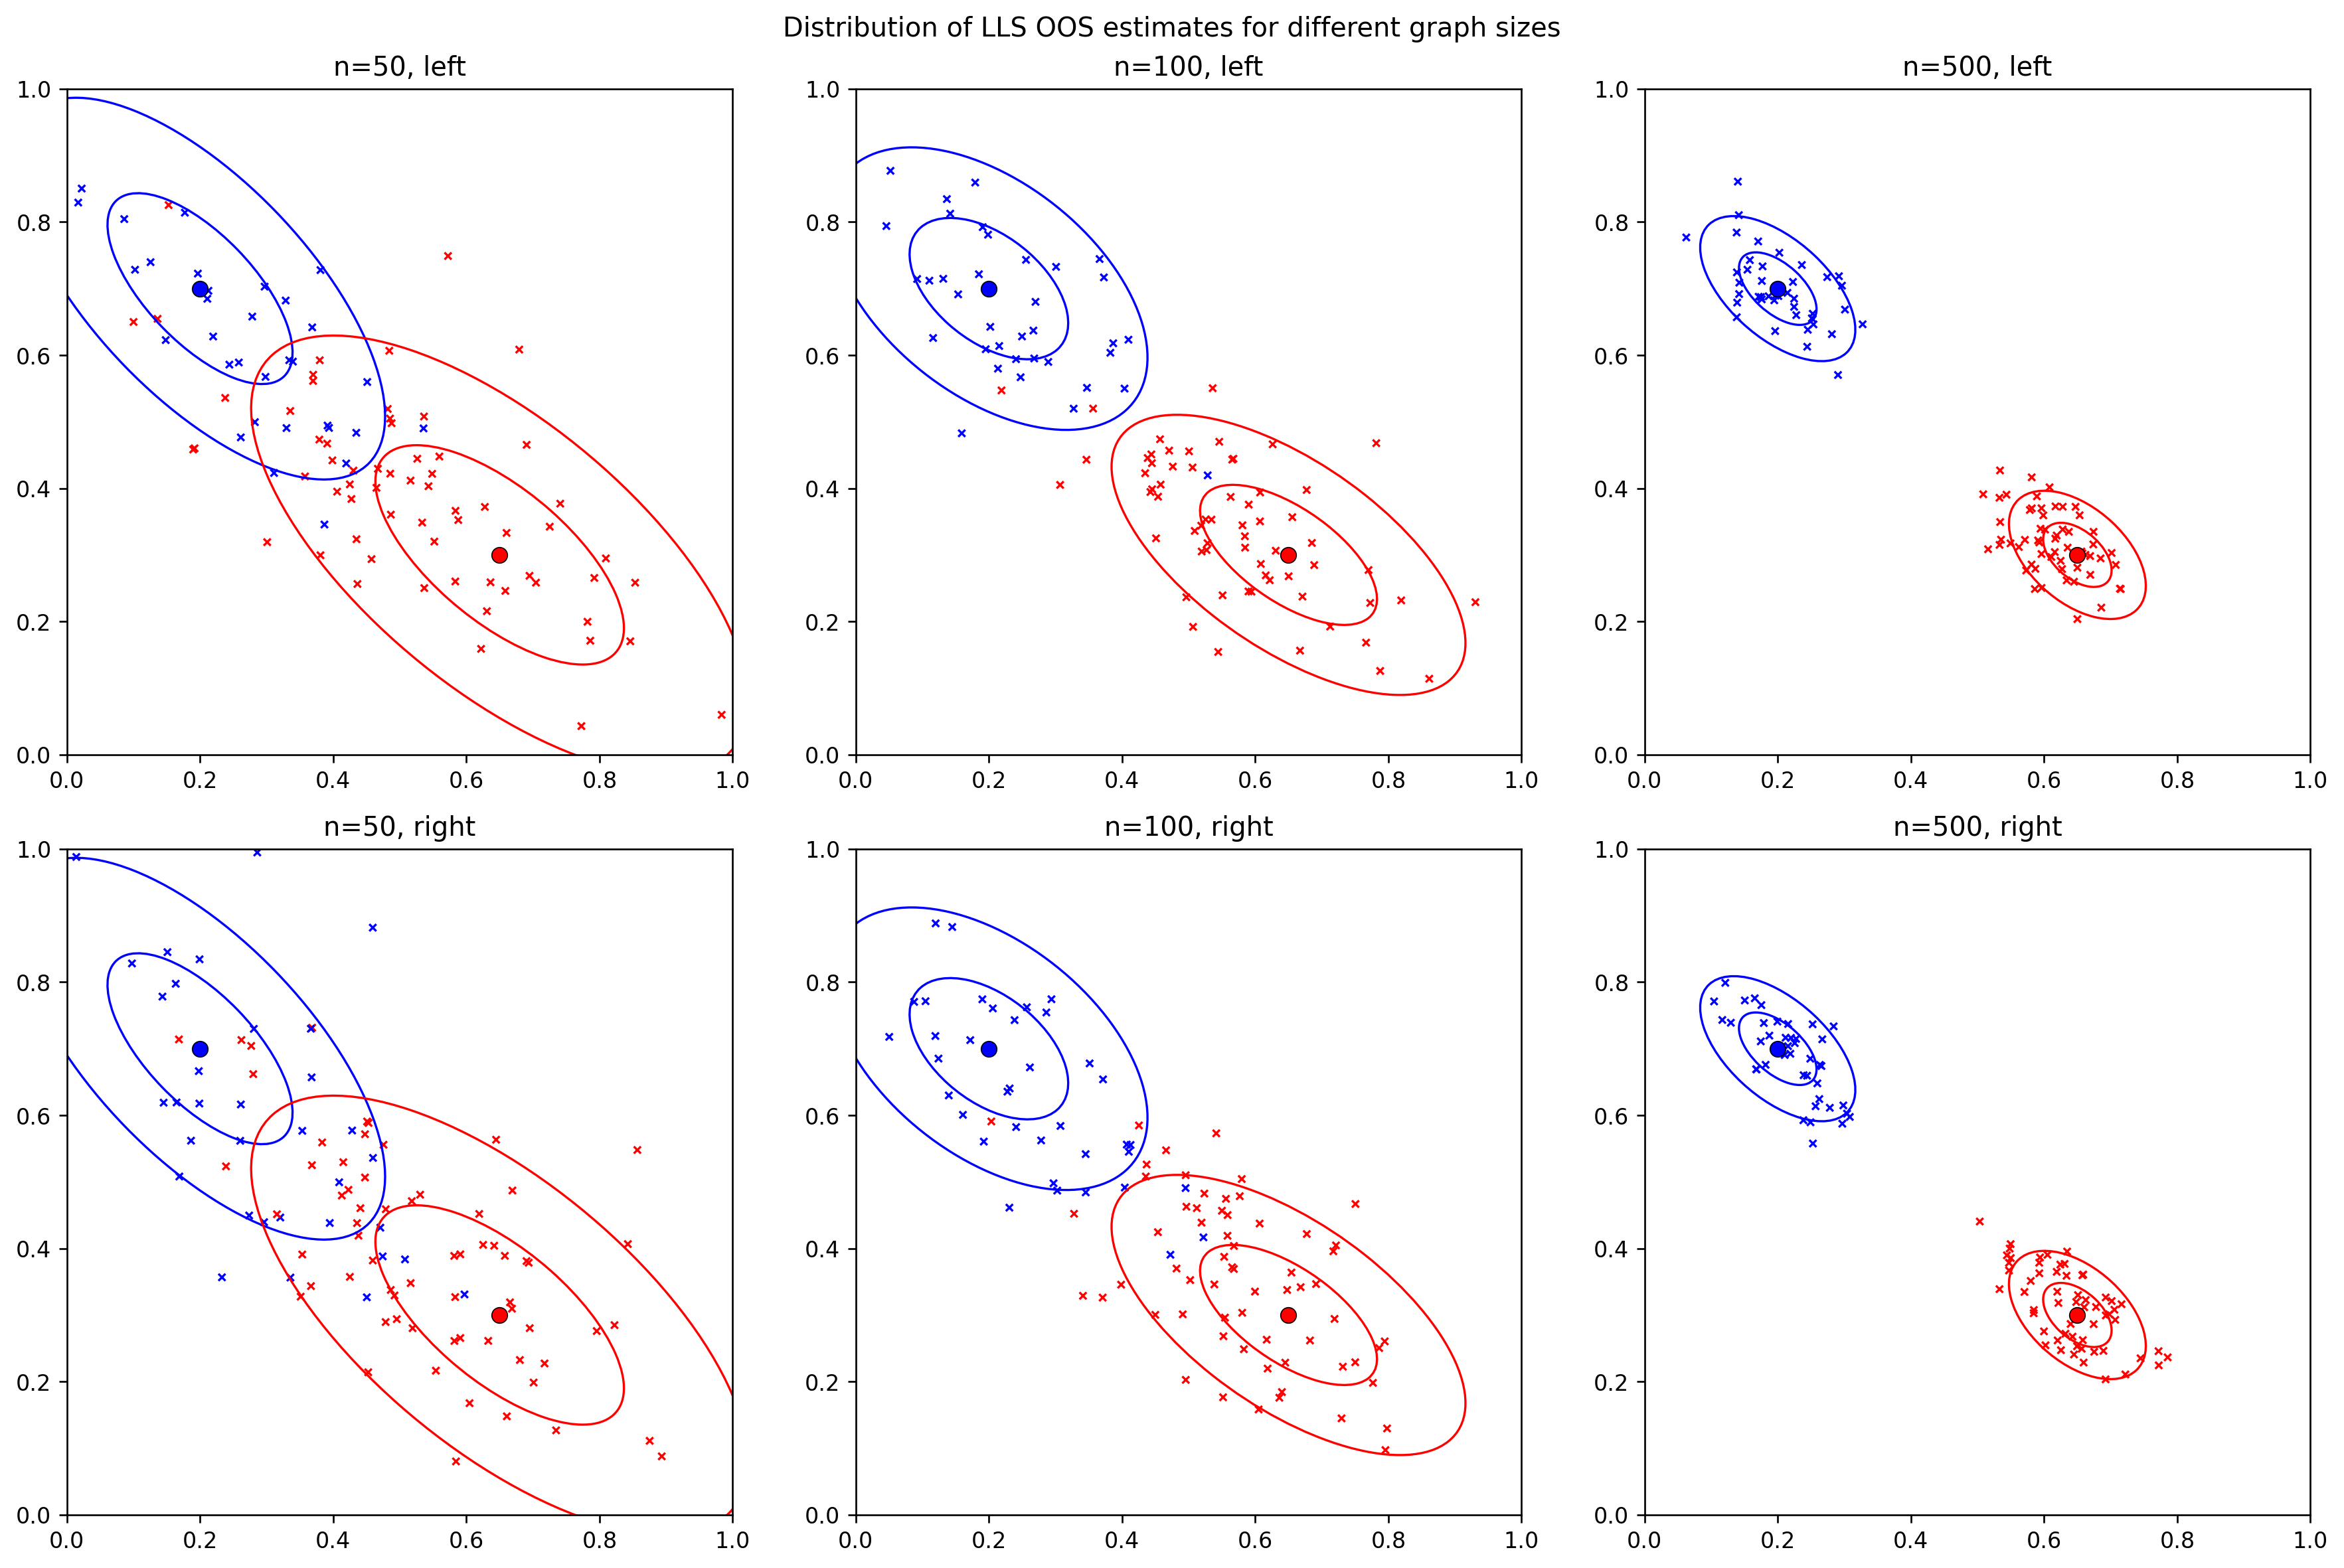

In [49]:
# run 100 trials and plot
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for i, n_ in enumerate([50, 100, 500]):
    n = n_ // 2
    ws = [[], []]
    labels = []
    for _ in tqdm(range(100)):
        w, label = trial(n, directed=True)
        ws[0].append(list(w[0]))  # from left latent positions
        ws[1].append(list(w[1]))  # from right latent positions
        labels.append(label)

    ws[0], ws[1] = np.array(ws[0]), np.array(ws[1])
    labels = np.array(labels)
    x_left, y_left = ws[0][:, 0], ws[0][:, 1]
    x_right, y_right = ws[1][:, 0], ws[1][:, 1]

    # separate labels and set parameters
    blues = ws[0][labels == 'blue']
    reds = ws[0][labels == 'red']
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])

    # plot
    sns.scatterplot(x_left, y_left, ax=axes[0, i], hue=labels, palette={'red': 'r', 'blue': 'b'}, marker='x', linewidth=1, s=10)
    sns.scatterplot(x_right, y_right, ax=axes[1, i], hue=labels, palette={'red': 'r', 'blue': 'b'}, marker='x', linewidth=1, s=10)
    axes[0, i].scatter(x1[0], x1[1], marker='o', c='b', s=50, edgecolors='k', linewidth=.5)
    axes[0, i].scatter(x2[0], x2[1], marker='o', c='r', s=50, edgecolors='k', linewidth=.5)
    axes[1, i].scatter(x1[0], x1[1], marker='o', c='b', s=50, edgecolors='k', linewidth=.5)
    axes[1, i].scatter(x2[0], x2[1], marker='o', c='r', s=50, edgecolors='k', linewidth=.5)
    for std in range(1, 3):
        confidence_ellipse(blues, ax=axes[0, i], mean=x1, n_std=std, edgecolor='b')
        confidence_ellipse(reds, ax=axes[0, i], mean=x2, n_std=std, edgecolor='r')
        confidence_ellipse(blues, ax=axes[1, i], mean=x1, n_std=std, edgecolor='b')
        confidence_ellipse(reds, ax=axes[1, i], mean=x2, n_std=std, edgecolor='r')

    # title
    axes[0, i].set_title(f'n={n_}, left')
    axes[1, i].set_title(f'n={n_}, right')

# universal axes properties
for ax in fig.get_axes():
    ax.get_legend().remove()
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# figure properties
fig.suptitle("Distribution of LLS OOS estimates for different graph sizes");
fig.tight_layout()

plt.savefig("../figs/oos_estimates_distribution.png", dpi=340)